In [1]:
!nvidia-smi

Tue Nov 30 22:32:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 58%   63C    P2   284W / 350W |   9165MiB / 24267MiB |     64%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    On   | 00000000:21:00.0 Off |                  Off |
| 57%   

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


Here we shall plot the number of samples in each class.\
In CIFAR100 dataset the samples are balanced at 500 samples per class.\
We will also define a function long tail that shall convert the\
balanced dataset into an unbalanced one given a dataset imbalance factor lamda.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_data_distribution(dataset, keyname="no name"):
    classes = dataset.classes
    dataset_elems = len(classes)*[0]
    for image, label in dataset:
        dataset_elems[label]+=1
    plt.bar(list(classes), dataset_elems)
    plt.title(keyname)
    plt.show()

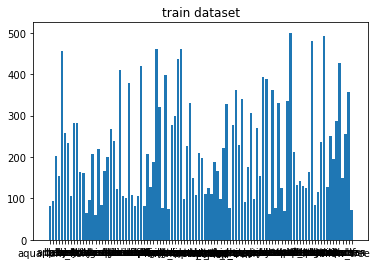

In [5]:
import random
def long_tail(dataset, lamda=1):
    num_classes = len(dataset.classes)
    class_indices = list(range(num_classes))
    random.shuffle(class_indices)
    class_probs = [lamda ** x for x in class_indices]
    select_list = []
    for i, (img, label) in enumerate(dataset):
        if np.random.binomial(1, class_probs[label]):
            select_list.append(i)
    dataset.data=dataset.data[np.array(select_list)]
    dataset.targets=list(dataset.targets[x] for x in select_list)
    return dataset


imabalanced_trainset = long_tail(trainset, lamda = 0.98)
show_data_distribution(imabalanced_trainset, keyname="train dataset")

In the training loop, we will be providing the optimizer, model,\
dataloader and the criterion i.e the loss function. We shall\
calculate a running loss that averages over the entire epoch and logs the same

In [6]:
def train(trainloader, optimizer, net, criterion, epoch):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            pass

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss = (running_loss*i + loss.item())/(i + 1)

    print("Finished Training Epoch :", epoch, " With the running loss : ", running_loss)
    return net

In [7]:
def test(testloader, net):
    net.eval()
    output_logs = []
    label_logs = []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
        else:
            pass

        labels = labels.numpy()
        outputs = torch.argmax(net(inputs), dim=1).cpu().detach().numpy()
        output_logs.append(outputs)
        label_logs.append(labels)
    print("Finished testing")
    return (np.concatenate(output_logs, axis=0), np.concatenate(label_logs, axis=0))

In the following function we shall feed all the outputs and the labels\
and the get metrics function shall return the following metrics of performance\
1. precision score class wise
2. max precision accross all class epochwise
3. min precision accross all class epochwise
4. mean precision *unweighted
5. recall score class wise
6. max recall accross all class epochwise
7. min recall accross all class epochwise
8. mean recall *unweighted
8. accuracy accross all class epochwise

In [8]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def get_metrics(outputs, labels):
    precision = precision_score(labels, outputs, average=None)
    max_precision = np.max(precision)
    min_precision = np.min(precision)
    mean_precision = np.mean(precision)
    
    recall = recall_score(labels, outputs, average=None)
    max_recall = np.max(recall)
    min_recall = np.min(recall)
    mean_recall = np.mean(recall)
    
    accuracy = accuracy_score(labels, outputs)
    return {
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "max_precision": max_precision,
            "mean_precision": mean_precision,
            "min_precision": min_precision,
            "max_recall": max_recall,
            "mean_recall": mean_recall,
            "min_recall": min_recall
            }

In [9]:
def loop(trainloader, testloader, net, optimizer, criterion, epochs=50):
    logs = []
    for i in range(epochs):
        net = train(trainloader, optimizer, net, criterion, epoch=i)
        outputs, labels = test(testloader, net)
        metrics = get_metrics(outputs, labels)
        logs.append(metrics)
    return logs

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_log(logs, lamda, classes, num_classes=10):
    precision = [x['precision'] for x in logs]
    recall = [x['recall'] for x in logs]
    accuracy = [x['accuracy'] for x in logs]

    len_logs = len(accuracy)

    max_precision = [x['max_precision'] for x in logs]
    min_precision = [x['min_precision'] for x in logs]
    mean_precision = [x['mean_precision'] for x in logs]

    max_recall = [x['max_recall'] for x in logs]
    min_recall = [x['min_recall'] for x in logs]
    mean_recall = [x['mean_recall'] for x in logs]

    plt.plot(list(range(len(max_precision))), max_precision, label = "max_precision")
    plt.plot(list(range(len(min_precision))), min_precision, label = "min_precision")
    plt.plot(list(range(len(mean_precision))), mean_precision, label = "mean_precision")

    plt.plot(list(range(len(max_recall))), max_recall, label = "max_recall")
    plt.plot(list(range(len(min_recall))), min_recall, label = "min_recall")
    plt.plot(list(range(len(mean_recall))), mean_recall, label = "mean_recall")

    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.title(' min mean and max precision and recalls for class imbalance rate  '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()


    precision = np.array(precision)
    recall = np.array(recall)
    for i in range(num_classes):
        plt.plot(list(range(len_logs)), precision[:, i].tolist(), label = classes[i])
        
    plt.xlabel('Epochs')
    plt.ylabel('Precision classwise')
    plt.title('Class wise precision for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

    for i in range(num_classes):
        plt.plot(list(range(len_logs)), recall[:, i].tolist(), label = classes[i])

    plt.xlabel('Epochs')
    plt.ylabel('Recall classwise')
    plt.title('Class wise recall for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(list(range(len(accuracy))), accuracy, label = "accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('Class wise accuracy for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

In [11]:
class Resnet18cifar(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.resnet18 = torch.hub.load('pytorch/vision:v0.8.0', 'resnet18', pretrained=pretrained)
        self.base = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))
        self.fc = torch.nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.base(x)
        x = x.reshape((-1, 512))
        x = self.fc(x)
        return x

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Files already downloaded and verified
Files already downloaded and verified


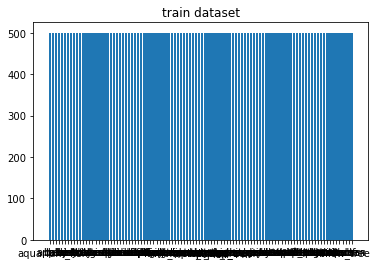

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


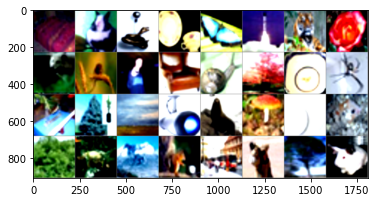

  bed rabbit snake plate butterfly rocket tiger  rose  wolf mouse   man chair snail maple_tree  bowl spider rocket pine_tree plain  lamp  seal mushroom plate hamster willow_tree forest mountain squirrel streetcar camel pine_tree rabbit
length of trainset 50000


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  3.226686265174198
Finished testing
Finished Training Epoch : 1  With the running loss :  2.1793606835760135
Finished testing
Finished Training Epoch : 2  With the running loss :  1.9110596172335204
Finished testing
Finished Training Epoch : 3  With the running loss :  1.774183695696137
Finished testing
Finished Training Epoch : 4  With the running loss :  1.6969078483294775
Finished testing
Finished Training Epoch : 5  With the running loss :  1.6367117418589985
Finished testing
Finished Training Epoch : 6  With the running loss :  1.5967153614328518
Finished testing
Finished Training Epoch : 7  With the running loss :  1.5603557232855558
Finished testing
Finished Training Epoch : 8  With the running loss :  1.531960414299505
Finished testing
Finished Training Epoch : 9  With the running loss :  1.5038889104635071
Finished testing
Finished Training Epoch : 10  With the running loss :  1.4844293558513653
Finished testing
Finished Tra

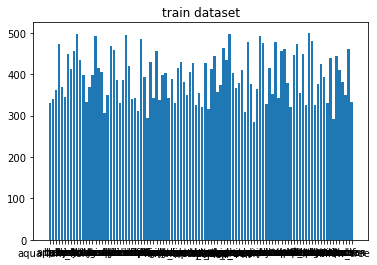

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


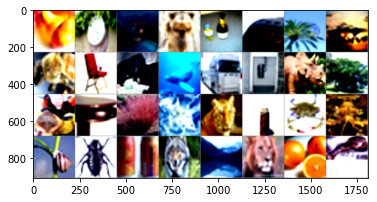

 pear clock lobster camel bottle clock palm_tree cloud   bee chair  bear whale   bus wardrobe dinosaur oak_tree flatfish table willow_tree shark tiger   can  crab lobster snail cockroach   can  wolf mountain  lion orange lobster
length of trainset 39469


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  3.3942926092317864
Finished testing
Finished Training Epoch : 1  With the running loss :  2.312339174013276
Finished testing
Finished Training Epoch : 2  With the running loss :  1.9915294751549062
Finished testing
Finished Training Epoch : 3  With the running loss :  1.8339378135807123
Finished testing
Finished Training Epoch : 4  With the running loss :  1.7451164917582636
Finished testing
Finished Training Epoch : 5  With the running loss :  1.6728350369431795
Finished testing
Finished Training Epoch : 6  With the running loss :  1.6231113524935428
Finished testing
Finished Training Epoch : 7  With the running loss :  1.5850222793255277
Finished testing
Finished Training Epoch : 8  With the running loss :  1.550787645520423
Finished testing
Finished Training Epoch : 9  With the running loss :  1.5263135570857678
Finished testing
Finished Training Epoch : 10  With the running loss :  1.5025201900175365
Finished testing
Finished Tr

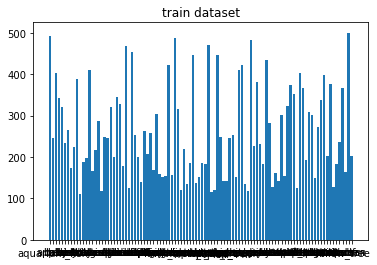

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


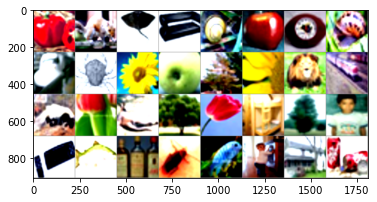

sweet_pepper squirrel   ray couch snail apple clock snail train  crab sunflower apple pine_tree sunflower  lion train skunk tulip kangaroo oak_tree tulip   bed maple_tree   boy keyboard trout bottle cockroach aquarium_fish  baby house   can
length of trainset 25896


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  3.5411059938831104
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  2.5238791627648434
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  2.148401051244618
Finished testing
Finished Training Epoch : 3  With the running loss :  1.9491198211540417
Finished testing
Finished Training Epoch : 4  With the running loss :  1.818465428882175
Finished testing
Finished Training Epoch : 5  With the running loss :  1.7327931417359255
Finished testing
Finished Training Epoch : 6  With the running loss :  1.6639479537069053
Finished testing
Finished Training Epoch : 7  With the running loss :  1.6142288706920764
Finished testing
Finished Training Epoch : 8  With the running loss :  1.562205316034363
Finished testing
Finished Training Epoch : 9  With the running loss :  1.5285378580476023
Finished testing
Finished Training Epoch : 10  With the running loss :  1.5012421508630123
Finished testing
Finished Training Epoch : 11  With the running loss :  1.4733193446088715
Finished testing
Finished Training Epoch : 12  With the running loss :  1.4539851558061299
Finished testing
Finished T

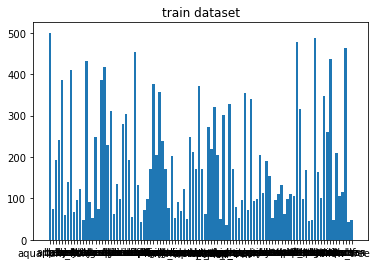

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


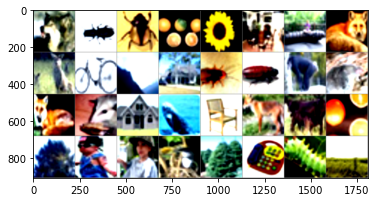

 wolf beetle beetle orange sunflower table caterpillar   fox kangaroo bicycle mountain house cockroach cockroach chimpanzee shrew   fox possum house whale chair   fox cattle orange pine_tree  baby   boy shrew pine_tree telephone caterpillar plain
length of trainset 18441


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  3.556181955585445
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  2.607520748672288
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  2.2309007863651305
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  2.0185288250756197
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  1.876414349835295
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  1.7760187753151773
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  1.6913013941700377
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  1.6310329675881043
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  1.586450171842526
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  1.5375023091686448
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  1.5030435724522888
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  1.4671788151590621
Finished testing
Finished Training Epoch : 12  With the running loss :  1.4384349244719359
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  1.4128120914488984
Finished testing
Finished Training Epoch : 14  With the running loss :  1.3953493174481852
Finished testing
Finished Training Epoch : 15  With the running loss :  1.3699285871441265
Finished testing
Finished Training Epoch : 16  With the running loss :  1.3498037493621453
Finished testing
Finished Training Epoch : 17  With the running loss :  1.3320681322591967
Finished testing
Finished Training Epoch : 18  With the running loss :  1.314124245370901
Finished testing
Finished Training Epoch : 19  With the running loss :  1.2963508565876274
Finished testing
Finished Training Epoch : 20  With the running loss :  1.2909686206944888
Finished testing
Finished Training Epoch : 21  With the running loss :  1.2709887337643306
Finished testing
Finished Training Epoch : 22  With the running loss :  1.2571952992750004
Finished testing
Finished Training Epoch : 23  With the running loss :  1.2375242553096084
Finished testing


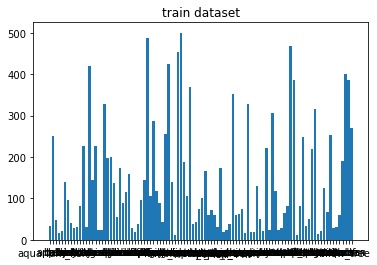

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


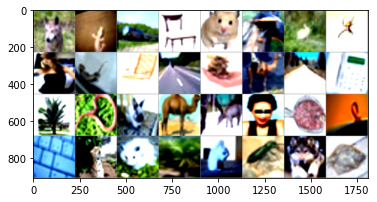

 wolf lizard train chair hamster mushroom rabbit spider woman lizard chair  road mouse camel  road telephone palm_tree snake rabbit camel dinosaur woman flatfish  worm keyboard leopard hamster palm_tree squirrel beetle  wolf flatfish
length of trainset 13816


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  3.4886811370099027
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  2.610794779327181
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  2.2636732806762003
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  2.0593533775320747
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  1.919134634512442
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  1.8133869913441163
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  1.735249619793009
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  1.6720758355050176
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  1.613542230868781
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  1.5688292769094307
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  1.528368042574989
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  1.4965980570349433
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  1.454222113445953
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  1.428224421761654
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  1.4076154840489232
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  1.3825812886158626
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  1.356756940484046
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  1.3392134424712934
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  1.3161826113031982
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  1.2970304286314382
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  1.2799505526544868
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  1.269548417517431
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  1.2495047890201758
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  1.2372474021933697
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 24  With the running loss :  1.2198391563638509
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  1.2043037058578603
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 26  With the running loss :  1.1968171382667852
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 27  With the running loss :  1.18401187699702
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 28  With the running loss :  1.1691255063094477
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 29  With the running loss :  1.1655944643749128
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  1.1584835360171621
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  1.145455385109892
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 32  With the running loss :  1.1346550793559478
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 33  With the running loss :  1.1228409804127841
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 34  With the running loss :  1.122888628531385
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 35  With the running loss :  1.1068276384914362
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 36  With the running loss :  1.1080170248945556
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 37  With the running loss :  1.1017645484319458
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 38  With the running loss :  1.0895644627787442
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 39  With the running loss :  1.0808337897890141
Finished testing
Finished Training Epoch : 40  With the running loss :  1.0787409877887477
Finished testing
Finished Training Epoch : 41  With the running loss :  1.0734323884050048
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 42  With the running loss :  1.0633592662160045
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 43  With the running loss :  1.0588456615805635
Finished testing
Finished Training Epoch : 44  With the running loss :  1.0560251813795825
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 45  With the running loss :  1.0529693345090867
Finished testing
Finished Training Epoch : 46  With the running loss :  1.0400147269721385
Finished testing
Finished Training Epoch : 47  With the running loss :  1.0257803923277942
Finished testing
Finished Training Epoch : 48  With the running loss :  1.0303414395699901
Finished testing
Finished Training Epoch : 49  With the running loss :  1.0227985816697276
Finished testing
Files already downloaded and verified
Files already downloaded and verified


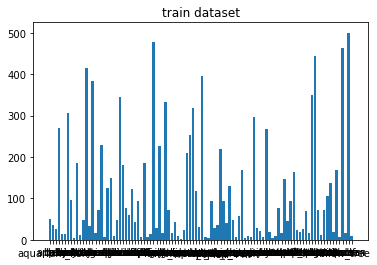

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


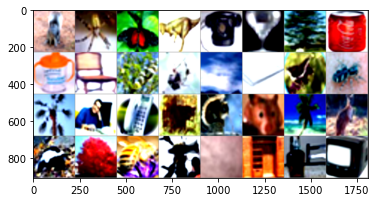

squirrel spider butterfly dinosaur telephone   cup pine_tree   can   cup chair willow_tree spider cloud keyboard butterfly spider palm_tree   man telephone  bear squirrel hamster palm_tree kangaroo skunk maple_tree   bee lobster cloud wardrobe bottle television
length of trainset 10958


Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


Finished Training Epoch : 0  With the running loss :  3.3542504352313776
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  2.476749493498844
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  2.1438294388462444
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  1.9386121979955333
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  1.8064216100787283
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  1.7057148242483333
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  1.63063229312007
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  1.5626455788709686
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  1.5084090291932442
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  1.45741760869763
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  1.4172150157283419
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  1.3844318919904721
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  1.3473200457436705
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  1.3171582864950409
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  1.2991359822951662
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  1.2677028733509275
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  1.2501177040550528
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  1.2368026712893052
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  1.2112647964029895
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  1.1884441372256942
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  1.168395430805385
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  1.1550564413167996
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  1.139468927772677
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  1.12710785066421
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 24  With the running loss :  1.119042289326559
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  1.0943680038952623
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 26  With the running loss :  1.090134546986127
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 27  With the running loss :  1.0668340580804008
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 28  With the running loss :  1.0718425491460903
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 29  With the running loss :  1.0495047612718518
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  1.0430733359937414
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  1.0322981447242099
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 32  With the running loss :  1.0251023320171653
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 33  With the running loss :  1.0104838159619558
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 34  With the running loss :  1.0091088400290242
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 35  With the running loss :  0.9877844473710908
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 36  With the running loss :  0.9914704787140336
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 37  With the running loss :  0.9813602423355113
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 38  With the running loss :  0.97329361263239
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 39  With the running loss :  0.963316278972014
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 40  With the running loss :  0.9596728012617406
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 41  With the running loss :  0.9518594383845872
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 42  With the running loss :  0.944147578133786
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 43  With the running loss :  0.9368089405336464
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 44  With the running loss :  0.9295916143728762
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 45  With the running loss :  0.9336596170424025
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 46  With the running loss :  0.9159796816614557
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 47  With the running loss :  0.90981295001055
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 48  With the running loss :  0.9041636159572933
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 49  With the running loss :  0.8920466320333954
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL

logs_by_lamda_resnet18_cifar100_transfer_learning = []
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([
    transforms.Resize(256, PIL.Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

batch_size = 32

for lamda in [1.0, 0.995, 0.985, 0.975, 0.965, 0.955]:
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
    trainset = long_tail(trainset, lamda)
    show_data_distribution(trainset, keyname="train dataset")

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))

    net = Resnet18cifar(100)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=50)
    logs_by_lamda_resnet18_cifar100_transfer_learning.append({lamda: logs})

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  1.0


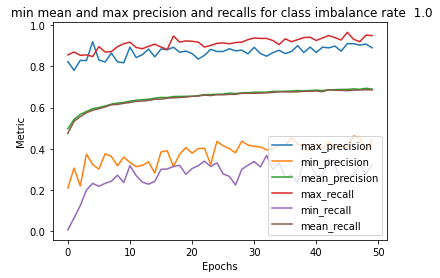

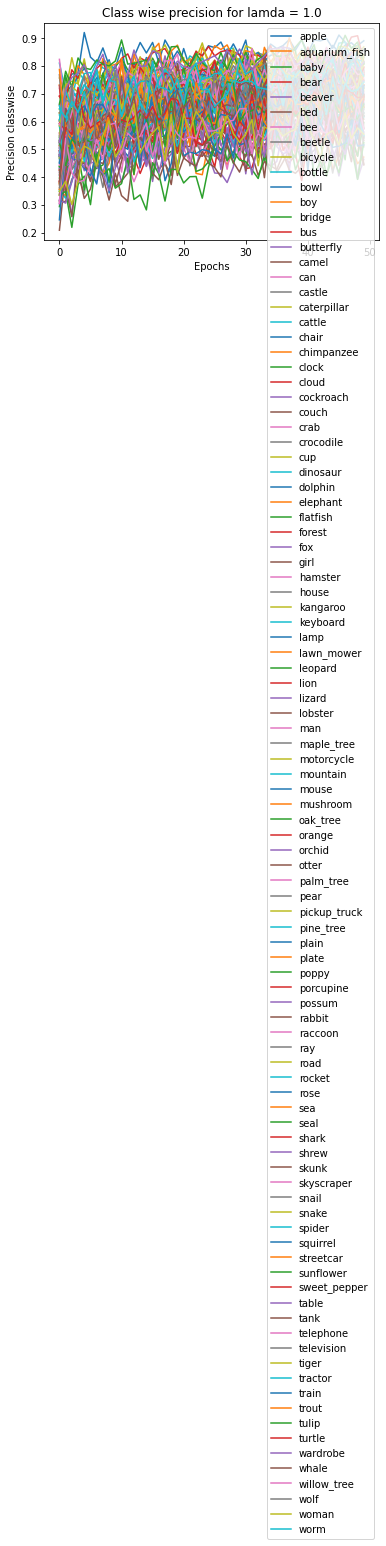

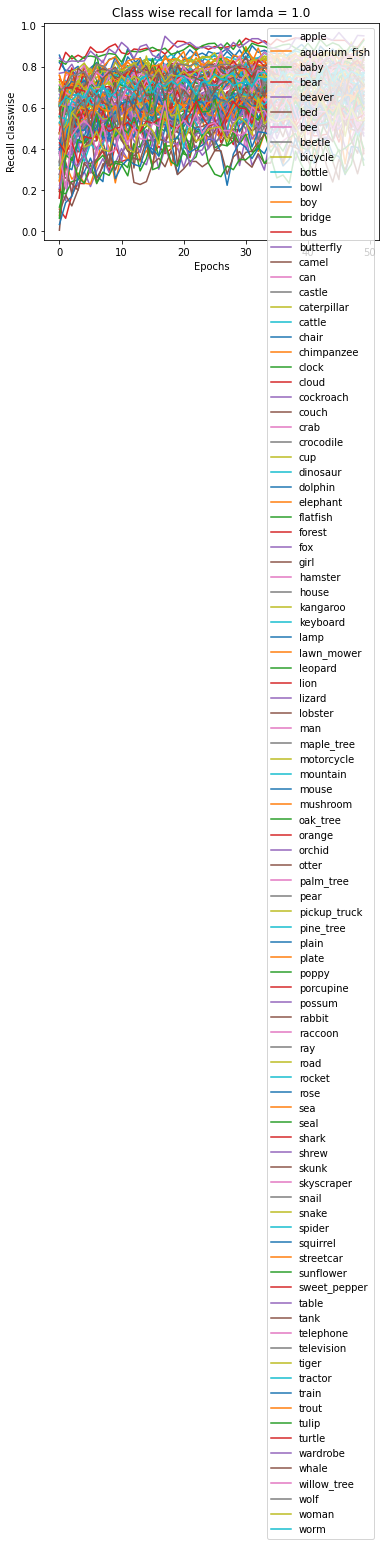

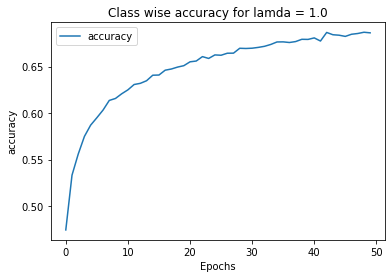

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.995


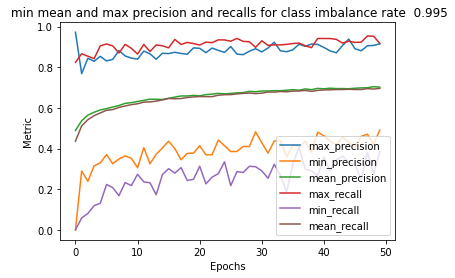

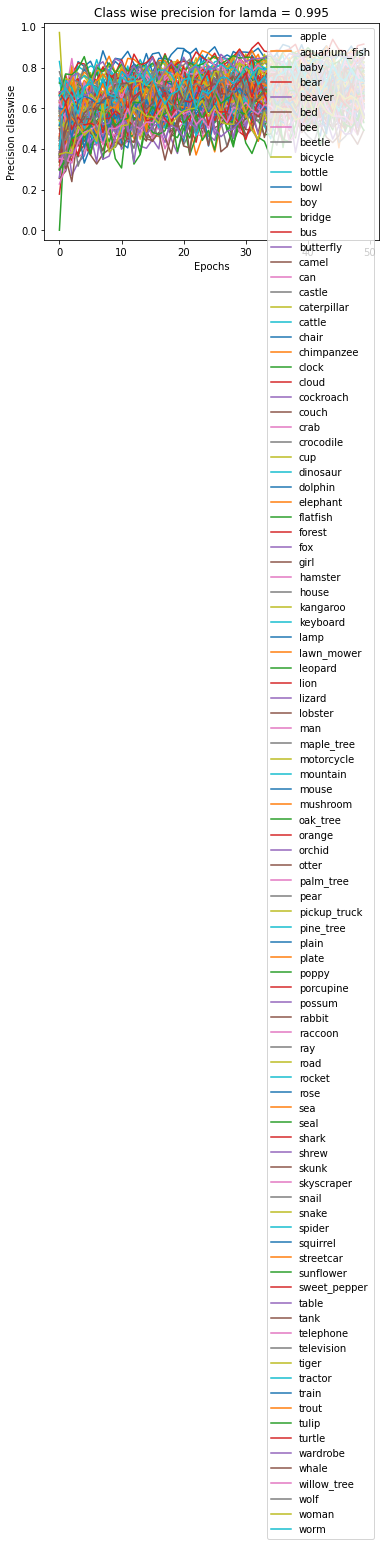

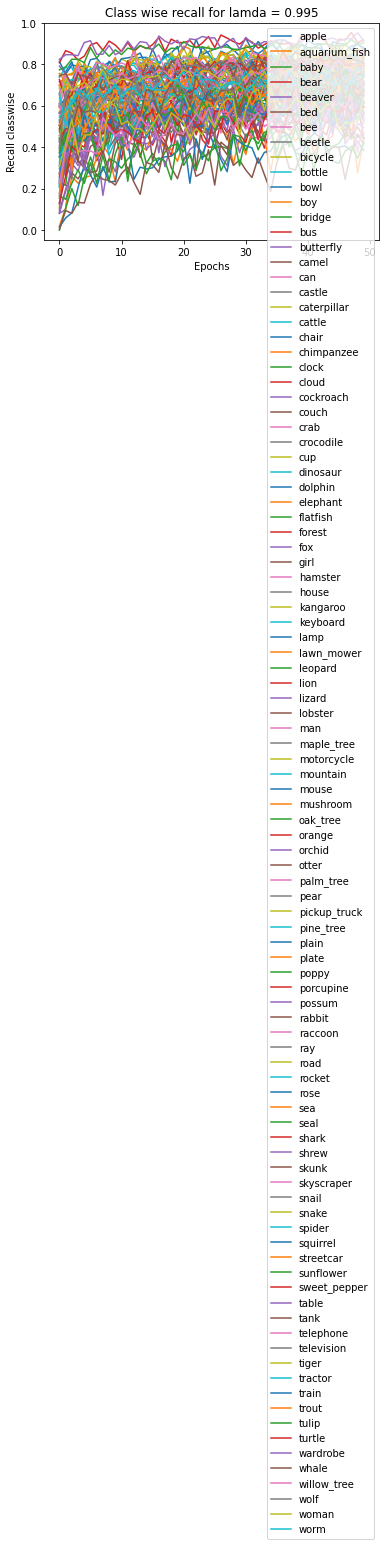

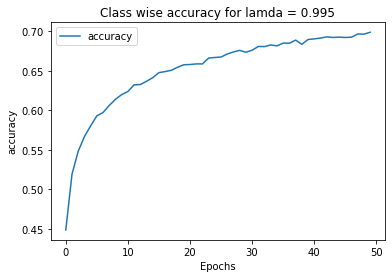

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.985


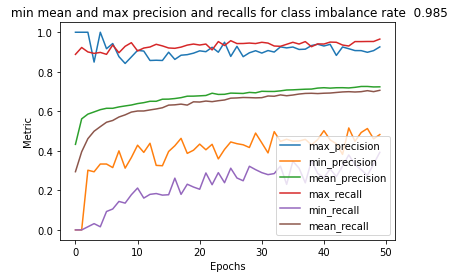

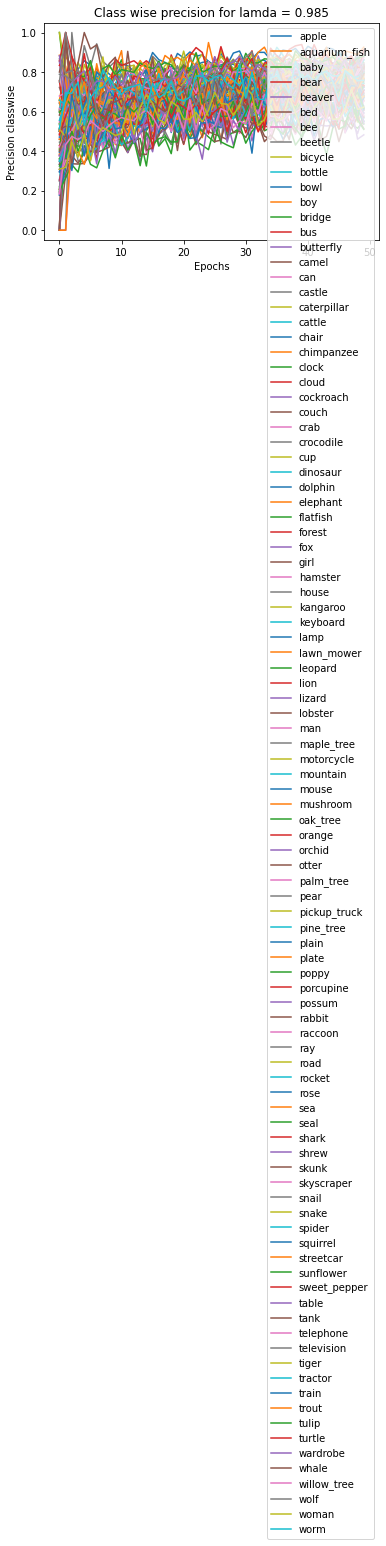

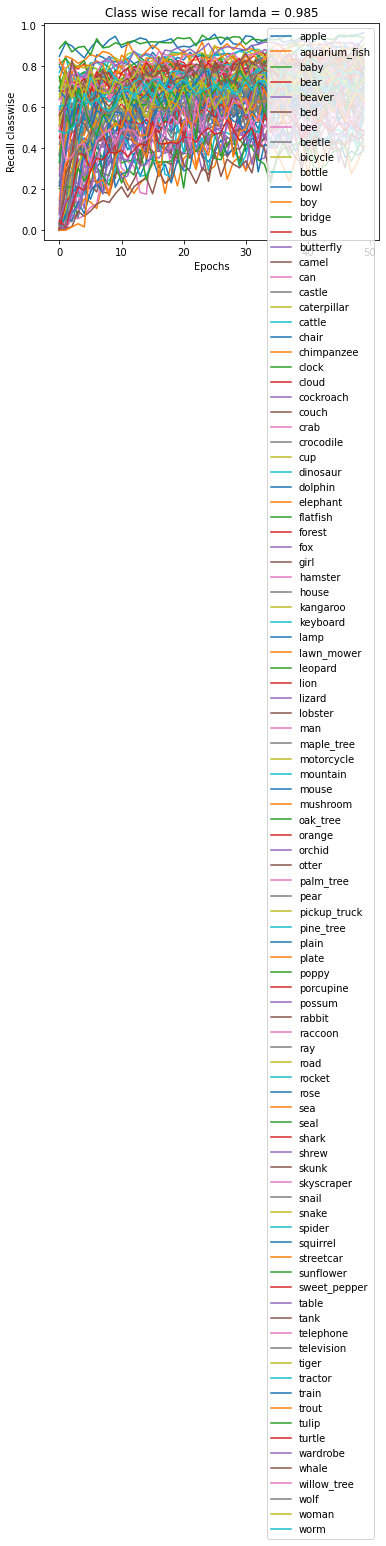

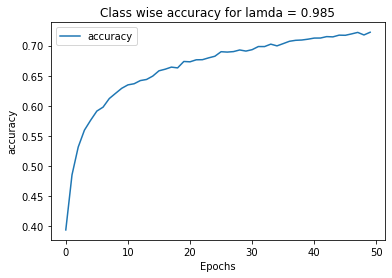

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.975


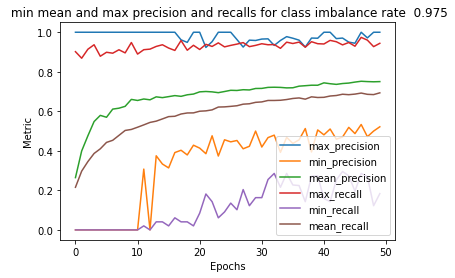

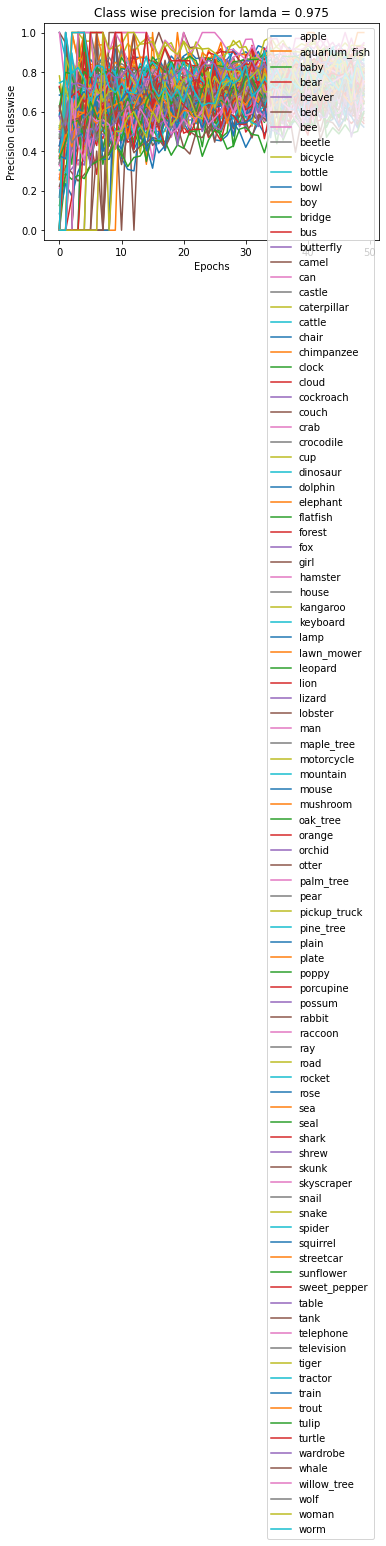

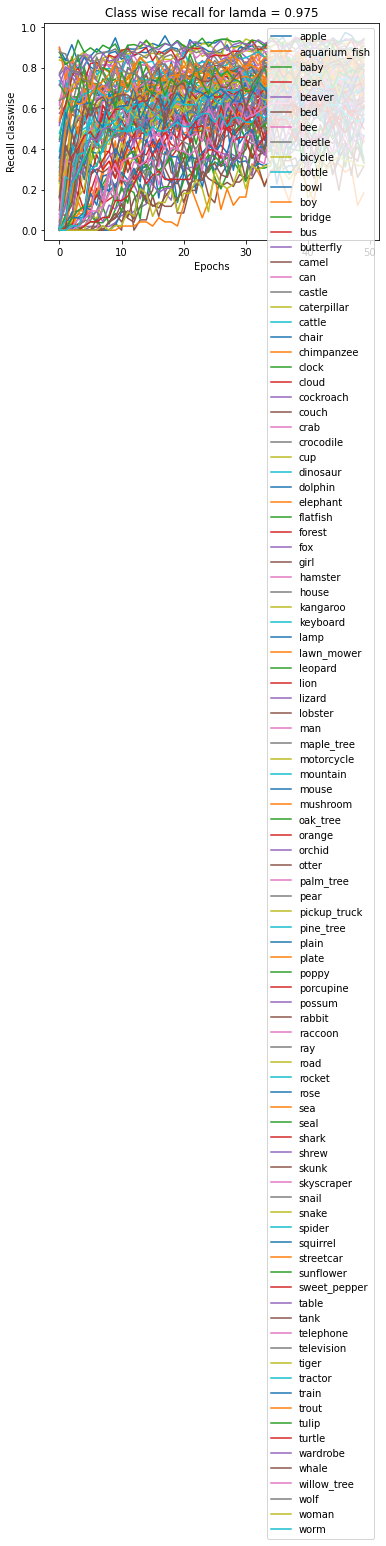

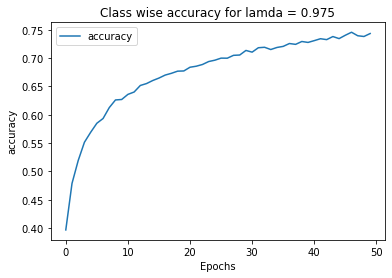

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.965


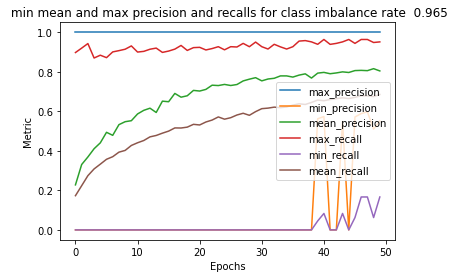

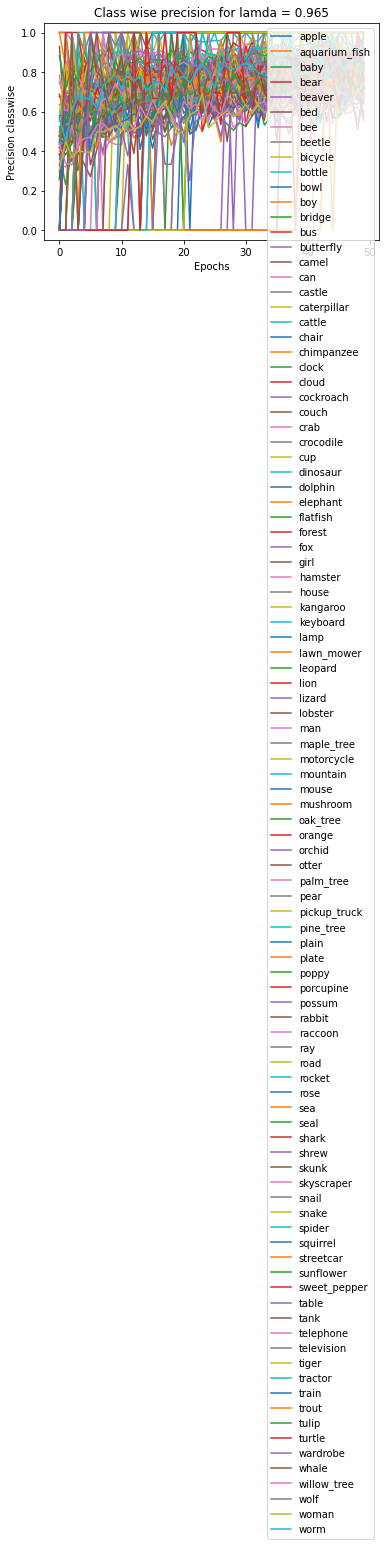

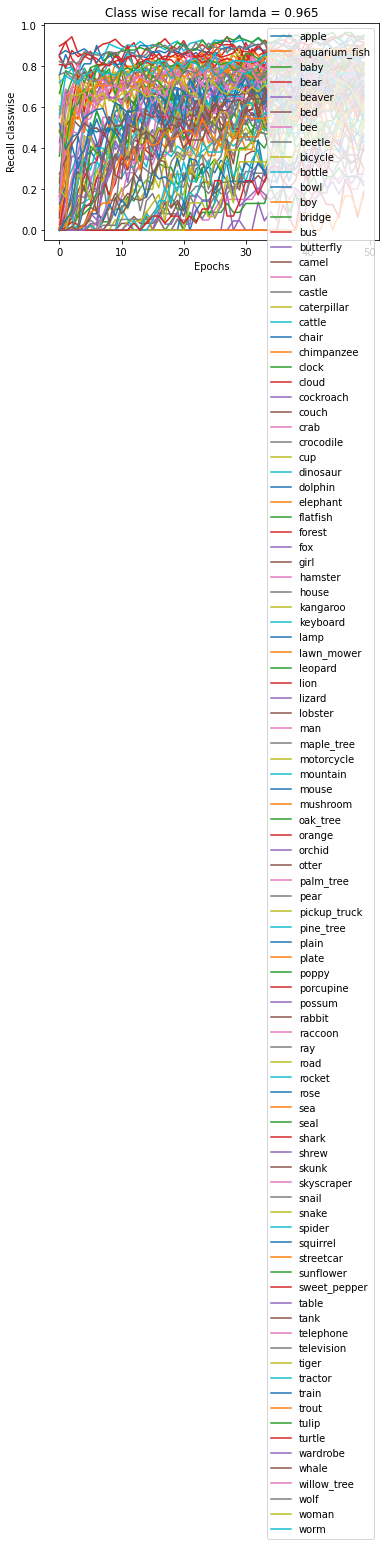

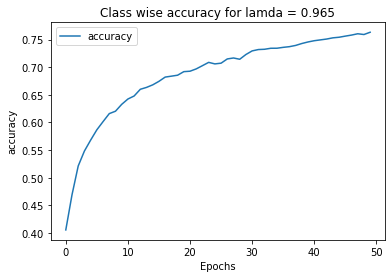

Files already downloaded and verified
THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER
THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.955


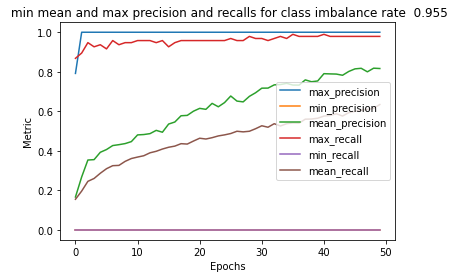

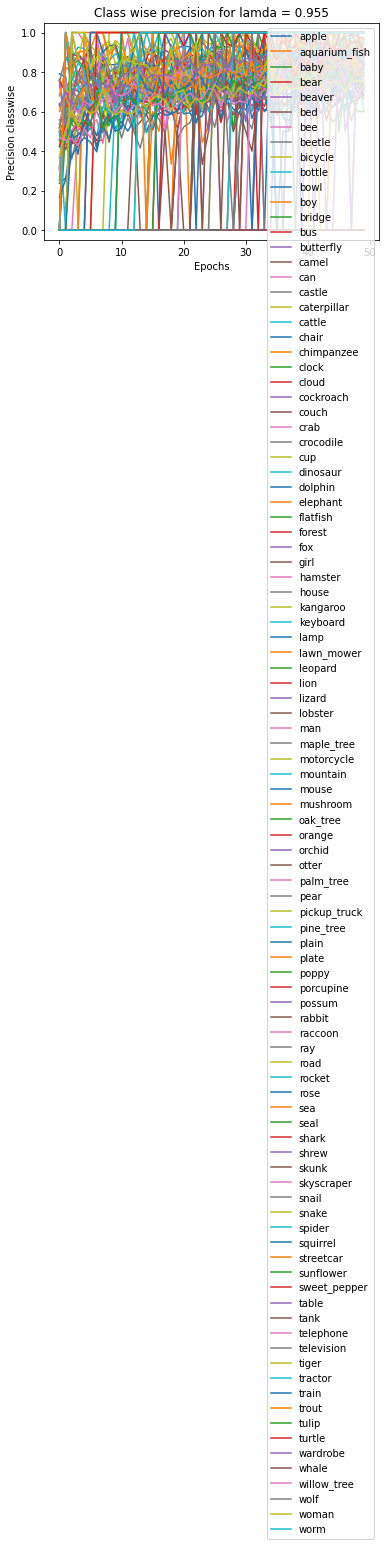

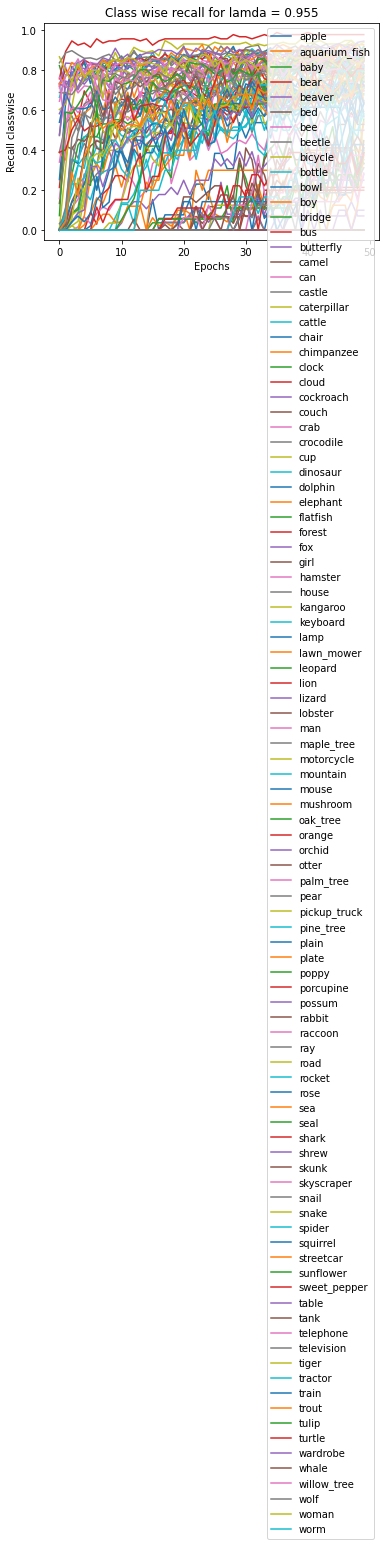

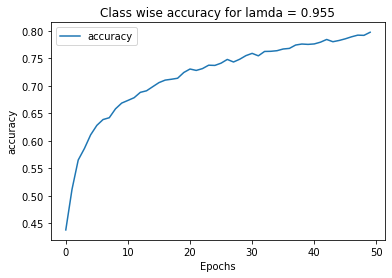

In [19]:
for log in logs_by_lamda_resnet18_cifar100_transfer_learning:
    lamda = list(log.keys())[0]
    log_data = log[lamda]
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
    print("=" * 30)
    print("THIS IS THE RESULT OF ONLY TRAINING A RESNET-18 CLASSIFICATION LAYER")
    print("THE MODEL WAS PRETRAINED ON IMAGENET-1K CLASSES")
    print("THE VALUE OF LAMDA IS ", lamda)
    print("=" * 30)
    plot_log(log_data, lamda, num_classes=len(trainset.classes), classes=trainset.classes)

In [ ]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL

logs_by_lamda_resnet18_cifar10 = []
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([
    transforms.Resize(256, PIL.Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])



for lamda in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75]:
    batch_size = 16
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    trainset = long_tail(trainset, 10, lamda)
    show_data_distribution(trainset, keyname="train dataset")

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))

    net = Resnet18cifar(10, pretrained=False)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=200)
    logs_by_lamda_resnet18_cifar10_transfer_learning.append({lamda: logs})